# Preliminaries

In [1]:
#!pip -q uninstall -y ocropus4inf || true
#!pip -q install git+https://github.com/ocropus/ocropus4inf
#!pip -q install plotly

In [2]:
%matplotlib inline

In [3]:
import os

os.environ["WDS_CACHE"] = "/tmp/ocropus_cache"
os.makedirs(os.environ["WDS_CACHE"], exist_ok=True)




In [4]:
import torch
a = torch.zeros(3, device="cuda:0")
import os
from ipywidgets import interact_manual 
from IPython.display import clear_output
import webdataset as wds
from itertools import islice
import ocropus4inf.ocrinf as inf
import matplotlib.pyplot as plt
import time
import numpy as np
import scipy.ndimage as ndi
#import display
from IPython.display import display

In [5]:
def ensure_size(image, size=(3000, 3000)):
    if image.shape[0] > size[0] or image.shape[1] > size[1]:
        zoom = min(size[0] / image.shape[0], size[1] / image.shape[1])
        if image.ndim == 2:
            image = ndi.zoom(image, zoom, order=1)
        else:
            image = ndi.zoom(image, (zoom, zoom, 1), order=1)
    return image

In [6]:
collections = {
  "Internet Archive (A)": "https://storage.googleapis.com/ocro-iaa/segs/books-{volume:06d}-segs.tar",
  "Internet Archive (1)": "https://storage.googleapis.com/ocro-ia1/nlbin/ia1-{volume:06d}.tar",
  "Google 1000 Books": "https://storage.googleapis.com/ocro-g1000/tess/Volume_{volume:04d}.tgz",
}
collnames = list(collections.keys())
volumes = [f"{i:06d}" for i in range(0, 1000)]
all_pages = [i for i in range(100)]
fontsizes = [4, 6, 8, 10, 12, 14, 18, 24]
preproc_modes = ["none", "binarize", "threshold"]
debug_steps = ["none", "seg_probs", "wordmap"]
figure_sizes = ["8,8", "12,12", "16,16", "20,20", "24,24"]


In [7]:
textmodel = None # use default
segmodel = None # use default
pagerec = inf.PageRecognizer(textmodel=textmodel, segmodel=segmodel, device="?cuda:0")

loading model /home/tmb/.cache/ocropus4/seg_unet_v2-default.jit
loading model /home/tmb/.cache/ocropus4/lstm_resnet_v2-default.jit


# Running the OCR

In [8]:
@interact_manual(collection=collnames, volume=volumes, pageno=all_pages, fontsize=fontsizes, preproc=preproc_modes, step=debug_steps, figure_size=figure_sizes)
def process_page(collection, volume, pageno=25, fontsize=8, preproc="none", step="none", figure_size="12,12"):
  clear_output(wait=True)
  figure_size = tuple(int(x) for x in figure_size.split(","))
  url = collections[collection].format(volume=int(volume))
  if step == "none":
    fig, ax = plt.subplots(1, 1, figsize=figure_size)
  else:
    fig, axs = plt.subplots(1, 2, figsize=figure_size)
  ds = wds.WebDataset(url).decode("l").to_tuple("jpg;jpeg;png")
  gray = next(islice(ds, pageno, pageno+1))[0]
  gray = ensure_size(gray)
  start = time.time()
  results = pagerec.recognize(gray, preproc=preproc)
  if step == "none":
    ax.set_title(f"{volume} {pageno} ({time.time()-start:.1f}s) {url}")
    pagerec.draw_overlaid(fontsize=fontsize, ax=ax)
  else:
    axs[0].set_title(f"{volume} {pageno} ({time.time()-start:.1f}s) {url}")
    pagerec.draw_overlaid(fontsize=fontsize, ax=axs[0])
    if step == "seg_probs":
      axs[1].imshow(pagerec.seg_probs[:,:,1:])
    elif step == "wordmap":
      inf.show_seg(pagerec.wordmap, ax=axs[1])

interactive(children=(Dropdown(description='collection', options=('Internet Archive (A)', 'Internet Archive (1…

# Pages that Need Fixing

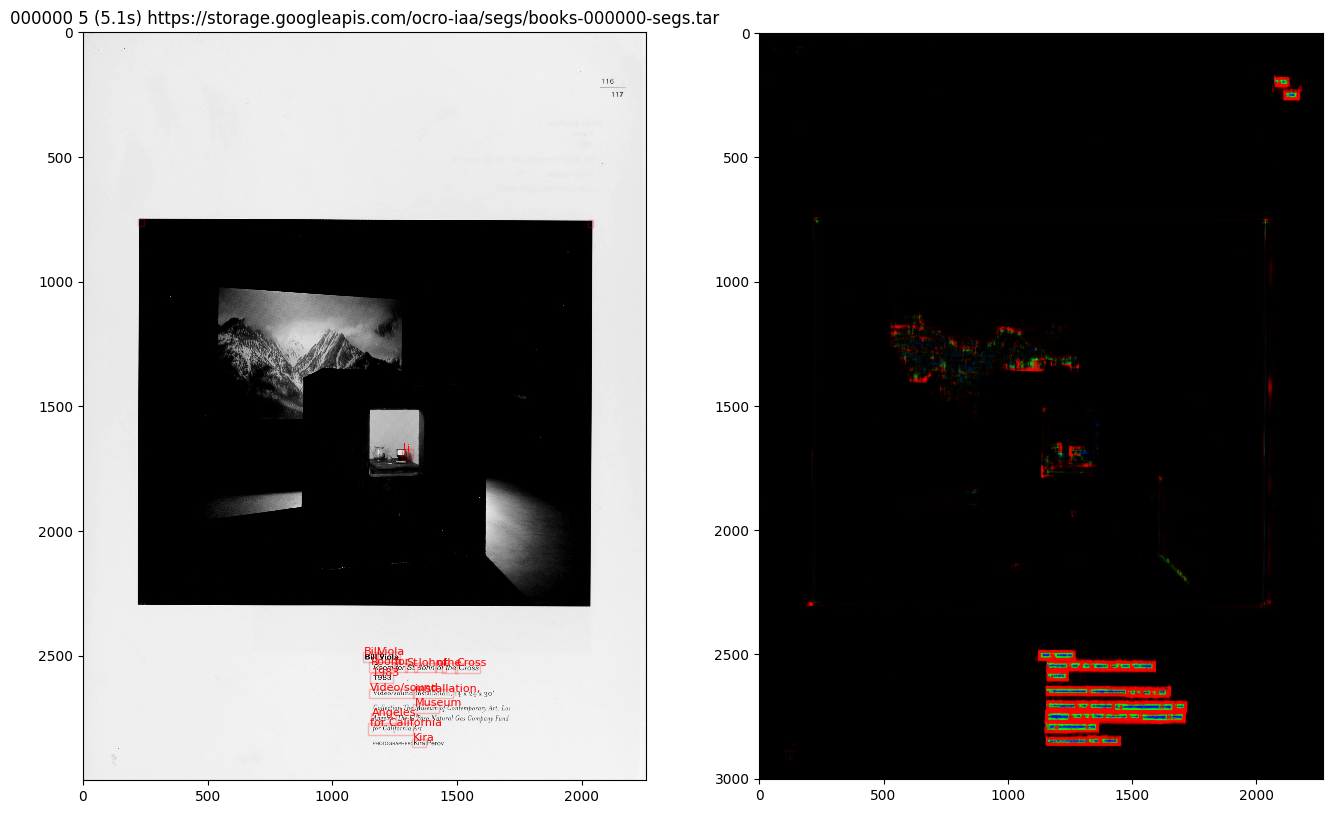

In [11]:
# for some reason, some of the bounding boxes are not picked up
process_page("Internet Archive (A)", volume="000000", pageno=5, fontsize=8, preproc="none", step="seg_probs", figure_size="16,16")